In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime as datetime

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ufc_fight_predictor/data/interleaved_reults.csv', dtype = {'DATE': 'str','opp_DATE': 'str'})
# Define a function to parse date columns
def parse_dates(date_col):
    try:
        return pd.to_datetime(date_col, format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(date_col, format='%Y-%m-%d %H:%M:%S')

data['DATE'] = data['DATE'].apply(parse_dates)
data['opp_DATE'] = data['opp_DATE'].apply(parse_dates)

data['DATE'] = pd.to_datetime(data['DATE'])
data['key'] = data['DATE'].astype(str) + data['BOUT']

In [ ]:
# Create separate DataFrames for winners and losers
winners_df = data[data['result'] == 1].copy()
losers_df = data[data['result'] == 0].copy()
winners_df.rename(columns={'FIGHTER': 'winner'}, inplace=True)
losers_df.rename(columns={'FIGHTER': 'loser'}, inplace=True)

# Merge winners and losers DataFrames to create a bout DataFrame
bout_data = pd.merge(winners_df[['BOUT', 'winner', 'DATE']], losers_df[['BOUT', 'loser', 'DATE']], on=['BOUT', 'DATE'])
bout_data.drop_duplicates(subset=['BOUT', 'winner', 'loser'], keep='first', inplace=True)
cleaned_data = bout_data[bout_data['winner'] != bout_data['loser']].copy()
cleaned_data.drop_duplicates(subset=['BOUT'], keep='first', inplace=True)
cleaned_data['key'] = cleaned_data['DATE'].astype(str) + cleaned_data['BOUT']

print(cleaned_data.head())

                                    BOUT              winner       DATE  \
0  Daniel Zellhuber vs. Esteban Ribovics    Esteban Ribovics 2024-09-14   
1          Raul Rosas Jr. vs. Aoriqileng      Raul Rosas Jr. 2024-09-14   
2           Edgar Chairez vs. Joshua Van          Joshua Van 2024-09-14   
3   Manuel Torres vs. Ignacio Bahamondes  Ignacio Bahamondes 2024-09-14   
4          Irene Aldana vs. Norma Dumont        Norma Dumont 2024-09-14   

              loser                                              key  
0  Daniel Zellhuber  2024-09-14Daniel Zellhuber vs. Esteban Ribovics  
1        Aoriqileng          2024-09-14Raul Rosas Jr. vs. Aoriqileng  
2     Edgar Chairez           2024-09-14Edgar Chairez vs. Joshua Van  
3     Manuel Torres   2024-09-14Manuel Torres vs. Ignacio Bahamondes  
4      Irene Aldana          2024-09-14Irene Aldana vs. Norma Dumont  


In [ ]:
class EnhancedElo:
    def __init__(self, k=32, decay_rate=5, base_rating=1500):
        self.rating_dict = {}  # Stores the Elo rating of each fighter
        self.last_fight_date = {}  # Stores the date of the last fight for each fighter
        self.k = k  # Factor for the maximum change in rating
        self.decay_rate = decay_rate  # Decay rate applied for each month of inactivity
        self.base_rating = base_rating  # Starting rating for new fighters

    def add_player(self, name, date):
        """Add a new player or update an existing player's inactivity decay in the Elo system."""
        if name not in self.rating_dict:
            self.rating_dict[name] = self.base_rating
            self.last_fight_date[name] = date
        else:
            # Calculate the decay based on inactivity time in months
            time_inactive = (date - self.last_fight_date[name]).days / 30
            decayed_rating = self.rating_dict[name] - self.decay_rate * time_inactive
            # Ensure the rating does not drop below a reasonable minimum, such as 1000
            self.rating_dict[name] = max(decayed_rating, 1000)
            self.last_fight_date[name] = date

    def calculate_elo(self, winner, loser, date, method=None):
        """Calculate and update the Elo ratings after a match."""
        # Retrieve current ratings; if missing, initialize to base_rating
        winner_rating = self.rating_dict.get(winner, self.base_rating)
        loser_rating = self.rating_dict.get(loser, self.base_rating)

        # Calculate the expected scores
        expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
        expected_loser = 1 / (1 + 10 ** ((winner_rating - loser_rating) / 400))

        # Method of victory adjustments
        method_weights = {'udec': 0.5, 'ko': 100, 'sub': 100}
        weight = method_weights.get(method, 1)

        # Update ratings based on match results and method of victory adjustments
        new_winner_rating = winner_rating + self.k * weight * (1 - expected_winner)
        new_loser_rating = loser_rating - self.k * weight * expected_loser

        # Store updated ratings
        self.rating_dict[winner] = new_winner_rating
        self.rating_dict[loser] = new_loser_rating

        # Update the date of the last fight
        self.last_fight_date[winner] = date
        self.last_fight_date[loser] = date


In [ ]:
elo_system = EnhancedElo(k=25, decay_rate=2)

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='DATE', ascending=True)

# Update and assign Elo ratings iteratively
for index, row in data.iterrows():
    fighter = row['FIGHTER']
    opponent = row['opp_FIGHTER']
    date = row['DATE']

    # Ensure both fighters are in the Elo system before the fight
    if fighter not in elo_system.rating_dict:
        elo_system.add_player(fighter, date)
    if opponent not in elo_system.rating_dict:
        elo_system.add_player(opponent, date)

    # Assign pre-competition Elo ratings before the fight
    data.at[index, 'precomp_elo'] = elo_system.rating_dict[fighter]
    data.at[index, 'opp_precomp_elo'] = elo_system.rating_dict[opponent]

    # Determine the winner and loser based on some criteria
    if row['result'] == 1:  # Adjust this condition based on your data
        winner, loser = fighter, opponent
    else:
        winner, loser = opponent, fighter

    """

    if ((row['subw'] > 0) | (row['subwd'] > 0)):
        method = 'sub'
    elif ((row['ko'] > 0) | (row['kod'] > 0)) > 0:
        method = 'ko'
    elif ((row['udec'] > 0) | (row['udecd'] > 0)) > 0:
        method = 'udec'
    else:
        method = 'udec'  # Default method if none is specified
    """

    # Update Elo ratings

    elo_system.calculate_elo(winner, loser, date)

    # Assign post-competition Elo ratings immediately after the fight
    data.at[index, 'postcomp_elo'] = elo_system.rating_dict[fighter]
    data.at[index, 'opp_postcomp_elo'] = elo_system.rating_dict[opponent]

# Debug: Print the last few entries to check the most recent updates
print(data.tail())

         DATE                              jbout                       jevent  \
17 2024-09-14           BrianOrtegavs.DiegoLopes  UFC306:RiyadhSeasonNocheUFC   
18 2024-09-14    SeanO'Malleyvs.MerabDvalishvili  UFC306:RiyadhSeasonNocheUFC   
19 2024-09-14    SeanO'Malleyvs.MerabDvalishvili  UFC306:RiyadhSeasonNocheUFC   
10 2024-09-14  AlexaGrassovs.ValentinaShevchenko  UFC306:RiyadhSeasonNocheUFC   
0  2024-09-14  DanielZellhubervs.EstebanRibovics  UFC306:RiyadhSeasonNocheUFC   

            jfighter                             EVENT  \
17        DiegoLopes  UFC 306: Riyadh Season Noche UFC   
18      SeanO'Malley  UFC 306: Riyadh Season Noche UFC   
19  MerabDvalishvili  UFC 306: Riyadh Season Noche UFC   
10       AlexaGrasso  UFC 306: Riyadh Season Noche UFC   
0    DanielZellhuber  UFC 306: Riyadh Season Noche UFC   

                                     BOUT            FIGHTER  \
17           Brian Ortega vs. Diego Lopes        Diego Lopes   
18    Sean O'Malley vs. Merab Dvalis

In [ ]:
# Calculate differences in Elo ratings for consecutive fights for both fighters and opponents
data['elo_prev_pre'] = data.groupby('FIGHTER')['precomp_elo'].diff().fillna(0)
data['elo_prev_post'] = data.groupby('FIGHTER')['postcomp_elo'].diff().fillna(0)
data['opp_elo_prev_pre'] = data.groupby('opp_FIGHTER')['opp_precomp_elo'].diff().fillna(0)
data['opp_elo_prev_post'] = data.groupby('opp_FIGHTER')['opp_postcomp_elo'].diff().fillna(0)

# Calculate rolling sums for the last 3 and 5 fights
data['precomp_elo_change_3'] = data.groupby('FIGHTER')['elo_prev_pre'].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
data['precomp_elo_change_5'] = data.groupby('FIGHTER')['elo_prev_pre'].rolling(5, min_periods=1).sum().reset_index(0, drop=True)
data['postcomp_elo_change_3'] = data.groupby('FIGHTER')['elo_prev_post'].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
data['postcomp_elo_change_5'] = data.groupby('FIGHTER')['elo_prev_post'].rolling(5, min_periods=1).sum().reset_index(0, drop=True)

data['opp_precomp_elo_change_3'] = data.groupby('opp_FIGHTER')['opp_elo_prev_pre'].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
data['opp_precomp_elo_change_5'] = data.groupby('opp_FIGHTER')['opp_elo_prev_pre'].rolling(5, min_periods=1).sum().reset_index(0, drop=True)
data['opp_postcomp_elo_change_3'] = data.groupby('opp_FIGHTER')['opp_elo_prev_post'].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
data['opp_postcomp_elo_change_5'] = data.groupby('opp_FIGHTER')['opp_elo_prev_post'].rolling(5, min_periods=1).sum().reset_index(0, drop=True)

# Since fillna(0) was previously used, if necessary, handle the NaN values differently
# Check the data to see if it needs further adjustment or if any NaN remains
print(data[['FIGHTER', 'precomp_elo_change_3', 'precomp_elo_change_5', 'postcomp_elo_change_3', 'postcomp_elo_change_5', 'opp_FIGHTER', 'opp_precomp_elo_change_3', 'opp_precomp_elo_change_5', 'opp_postcomp_elo_change_3', 'opp_postcomp_elo_change_5']].tail())

              FIGHTER  precomp_elo_change_3  precomp_elo_change_5  \
17        Diego Lopes            102.158078             84.613392   
18      Sean O'Malley             81.200524            119.297344   
19  Merab Dvalishvili             72.613271            132.419011   
10       Alexa Grasso             49.841630             95.132820   
0    Daniel Zellhuber             45.722724             32.942095   

    postcomp_elo_change_3  postcomp_elo_change_5           opp_FIGHTER  \
17             100.783030             107.922703          Brian Ortega   
18              55.321464              97.132132     Merab Dvalishvili   
19              71.156521             131.675621         Sean O'Malley   
10              27.510694              72.081514  Valentina Shevchenko   
0               21.591005              34.061030      Esteban Ribovics   

    opp_precomp_elo_change_3  opp_precomp_elo_change_5  \
17                -33.334124                -29.164085   
18                 74.17

In [ ]:
# Filter the DataFrame to remove fights where either fighter or opponent is having their first fight
filtered_data = data[(data['precomp_boutcount'] > 1) & (data['opp_precomp_boutcount'] > 1)]

# Now you can work with 'filtered_data' which excludes first fights for any fighter or their opponent
print(filtered_data[['FIGHTER', 'opp_FIGHTER', 'precomp_boutcount', 'opp_precomp_boutcount']].head())

# Optionally, check the size of the original vs filtered data to see how many rows were removed
print(f"Original data count: {len(data)}, Filtered data count: {len(filtered_data)}")

            FIGHTER   opp_FIGHTER  precomp_boutcount  opp_precomp_boutcount
15016  Ken Shamrock    Dan Severn                  4                     18
15017    Dan Severn  Ken Shamrock                 18                      4
15014    Dan Severn  David Abbott                 20                      9
15013  David Abbott    Dan Severn                 10                     20
15012    Dan Severn  David Abbott                 20                     10
Original data count: 15024, Filtered data count: 8336


In [ ]:
sorted_fighters_by_elo = sorted(elo_system.rating_dict.items(), key=lambda item: item[1], reverse=True)
top_10_fighters = sorted_fighters_by_elo[:60]

for rank, (fighter, rating) in enumerate(top_10_fighters, start=1):
    print(f"{rank}. {fighter}: {rating:.2f}")

1. Jon Jones: 1857.22
2. Georges St-Pierre: 1845.64
3. Islam Makhachev: 1806.14
4. Belal Muhammad: 1780.66
5. Khabib Nurmagomedov: 1779.17
6. Max Holloway: 1772.94
7. Leon Edwards: 1764.81
8. Aljamain Sterling: 1751.25
9. Francis Ngannou: 1747.39
10. Amanda Nunes: 1742.14
11. Robert Whittaker: 1737.34
12. Stipe Miocic: 1733.35
13. Kamaru Usman: 1733.15
14. Demetrious Johnson: 1729.80
15. Charles Oliveira: 1724.89
16. Merab Dvalishvili: 1723.97
17. Dustin Poirier: 1720.62
18. Alexander Volkanovski: 1719.10
19. Dricus Du Plessis: 1716.04
20. Deiveson Figueiredo: 1713.83
21. Daniel Cormier: 1706.91
22. Brendan Allen: 1706.06
23. Valentina Shevchenko: 1703.38
24. Colby Covington: 1695.78
25. Alex Pereira: 1694.90
26. Beneil Dariush: 1690.36
27. Alexander Volkov: 1689.63
28. Alexandre Pantoja: 1689.41
29. Sean Strickland: 1689.28
30. Israel Adesanya: 1687.02
31. Arman Tsarukyan: 1684.84
32. Ryan Bader: 1684.49
33. Ciryl Gane: 1683.33
34. Khamzat Chimaev: 1681.72
35. Tom Aspinall: 1681.52
36

In [ ]:
# Assuming 'FIGHTER' is the column for the fighter's name, and 'OPPONENT' for the opponent's name
# Adjust column names as per your DataFrame's structure

# Filter rows where Alexander Volkanovski is either the fighter or the opponent
volkanovski_fights = data[(data['FIGHTER'] == 'Alexander Volkanovski') | (data['opp_FIGHTER'] == 'Alexander Volkanovski')]

# Select and rename columns as necessary to display the required information
volkanovski_fights = volkanovski_fights[['DATE', 'BOUT', 'FIGHTER', 'opp_FIGHTER', 'result', 'precomp_elo', 'opp_precomp_elo', 'postcomp_elo', 'opp_postcomp_elo']]

# Rename columns for clarity when Alexander Volkanovski is the opponent
volkanovski_fights.loc[volkanovski_fights['opp_FIGHTER'] == 'Alexander Volkanovski', ['precomp_elo', 'opp_precomp_elo']] = volkanovski_fights.loc[volkanovski_fights['opp_FIGHTER'] == 'Alexander Volkanovski', ['opp_precomp_elo', 'precomp_elo']].values
volkanovski_fights.loc[volkanovski_fights['opp_FIGHTER'] == 'Alexander Volkanovski', ['postcomp_elo', 'opp_postcomp_elo']] = volkanovski_fights.loc[volkanovski_fights['opp_FIGHTER'] == 'Alexander Volkanovski', ['opp_postcomp_elo', 'postcomp_elo']].values

# Ensure the dates are sorted to follow the chronological order of the fights
volkanovski_fights = volkanovski_fights.sort_values(by='DATE')

# Print the history of fights
print(volkanovski_fights)

           DATE                                       BOUT  \
7550 2016-11-26    Yusuke Kasuya vs. Alexander Volkanovski   
7551 2016-11-26    Yusuke Kasuya vs. Alexander Volkanovski   
7098 2017-06-10    Alexander Volkanovski vs. Mizuto Hirota   
7099 2017-06-10    Alexander Volkanovski vs. Mizuto Hirota   
6675 2017-11-18      Alexander Volkanovski vs. Shane Young   
6674 2017-11-18      Alexander Volkanovski vs. Shane Young   
6434 2018-02-10   Alexander Volkanovski vs. Jeremy Kennedy   
6435 2018-02-10   Alexander Volkanovski vs. Jeremy Kennedy   
6053 2018-07-14    Darren Elkins vs. Alexander Volkanovski   
6052 2018-07-14    Darren Elkins vs. Alexander Volkanovski   
5617 2018-12-29      Chad Mendes vs. Alexander Volkanovski   
5616 2018-12-29      Chad Mendes vs. Alexander Volkanovski   
5262 2019-05-11        Jose Aldo vs. Alexander Volkanovski   
5263 2019-05-11        Jose Aldo vs. Alexander Volkanovski   
4649 2019-12-14     Max Holloway vs. Alexander Volkanovski   
4648 201

In [ ]:
# Assuming 'FIGHTER' represents the individual's name and 'postcomp_elo' their Elo after a competition

# Group by fighter name, then get the maximum post-competition Elo rating for each fighter
top_individuals = data.groupby('FIGHTER')['postcomp_elo'].max().reset_index()

# Sort the results by the post-competition Elo rating in descending order
top_individuals = top_individuals.sort_values(by='postcomp_elo', ascending=False)

# Select the top 10 entries
top_individuals = top_individuals.head(10)

# Display the results
print(top_individuals)

                    FIGHTER  postcomp_elo
1163              Jon Jones   1857.218680
817       Georges St-Pierre   1837.699393
1285           Kamaru Usman   1824.251922
926         Islam Makhachev   1806.138898
116          Anderson Silva   1801.543476
1398           Leon Edwards   1781.708768
215          Belal Muhammad   1780.664057
1340    Khabib Nurmagomedov   1779.169571
81    Alexander Volkanovski   1775.322481
1587           Max Holloway   1772.936943


<ipython-input-19-1bf3acdc723e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_df['DATE'] = pd.to_datetime(fighter_df['DATE'])


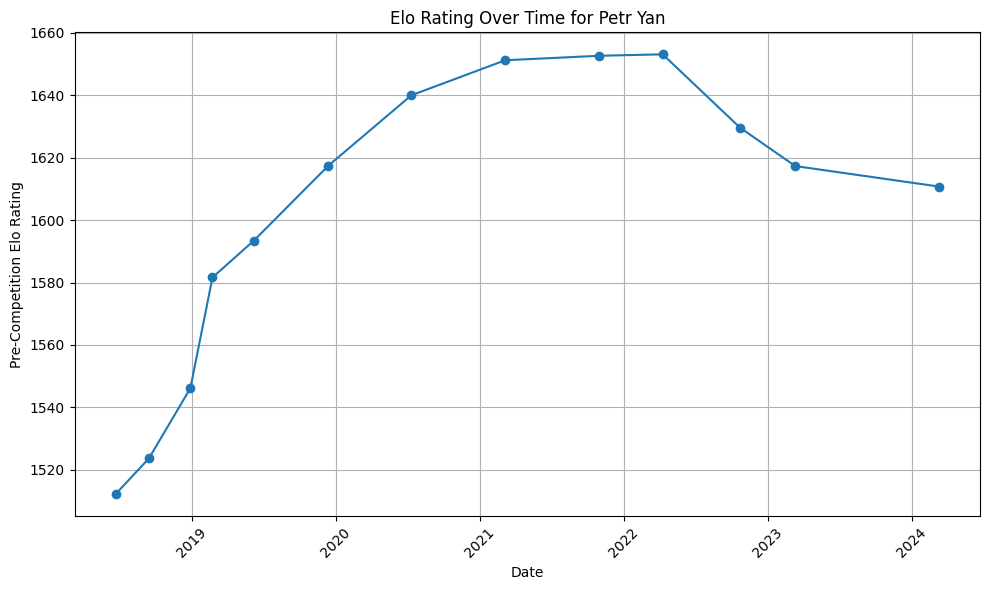

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for a specific fighter (e.g., "Fighter A")
fighter_name = "Petr Yan"  # Replace with the desired fighter's name
fighter_df = data[data['FIGHTER'] == fighter_name]

# Sort the data by date to ensure a chronological timeline
fighter_df['DATE'] = pd.to_datetime(fighter_df['DATE'])
fighter_df = fighter_df.sort_values('DATE')

# Plot the precomp_elo values over time
plt.figure(figsize=(10, 6))
plt.plot(fighter_df['DATE'], fighter_df['precomp_elo'], marker='o', linestyle='-')
plt.title(f"Elo Rating Over Time for {fighter_name}")
plt.xlabel("Date")
plt.ylabel("Pre-Competition Elo Rating")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data.head(5)

,DATE,jbout,jevent,jfighter,EVENT,BOUT,FIGHTER,fight_time_minutes,precomp_tot_time_in_cage,postcomp_tot_time_in_cage,...,opp_elo_prev_pre,opp_elo_prev_post,precomp_elo_change_3,precomp_elo_change_5,postcomp_elo_change_3,postcomp_elo_change_5,opp_precomp_elo_change_3,opp_precomp_elo_change_5,opp_postcomp_elo_change_3,opp_postcomp_elo_change_5
15023,1995-04-07,DanSevernvs.JoeCharles,UFC5:TheReturnoftheBeast,JoeCharles,UFC 5: The Return of the Beast,Dan Severn vs. Joe Charles,Joe Charles,1,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15018,1995-04-07,DanSevernvs.JoeCharles,UFC5:TheReturnoftheBeast,DanSevern,UFC 5: The Return of the Beast,Dan Severn vs. Joe Charles,Dan Severn,3,56,59,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15019,1995-04-07,DanSevernvs.JoeCharles,UFC5:TheReturnoftheBeast,JoeCharles,UFC 5: The Return of the Beast,Dan Severn vs. Joe Charles,Joe Charles,1,0,1,...,24.102102,22.378859,-24.102102,-24.102102,-22.378859,-22.378859,24.102102,24.102102,22.378859,22.378859
15022,1995-04-07,DanSevernvs.JoeCharles,UFC5:TheReturnoftheBeast,DanSevern,UFC 5: The Return of the Beast,Dan Severn vs. Joe Charles,Dan Severn,4,60,64,...,-22.378859,-20.800211,22.378859,22.378859,20.800211,20.800211,-22.378859,-22.378859,-20.800211,-20.800211
15021,1995-04-07,DanSevernvs.JoeCharles,UFC5:TheReturnoftheBeast,JoeCharles,UFC 5: The Return of the Beast,Dan Severn vs. Joe Charles,Joe Charles,1,0,1,...,20.800211,19.362555,-44.902313,-44.902313,-41.741415,-41.741415,44.902313,44.902313,41.741415,41.741415


# things to fix in the elo
* over counting decay rate because some fighters are retired but it's still basing off their last fight. Find a way to determin when their last fight was and if it's past a certain date, consider them retired
*

In [ ]:

# Specify the filename
output_filename = '/content/drive/MyDrive/ufc_fight_predictor/data/interleaved_results_elo_hist_1_removed.csv'

# Export the DataFrame to a CSV file
filtered_data.to_csv(output_filename, index=False)

# Code to download the file to your local machine (optional)
from google.colab import files
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>